

>Dataset download



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)


100%|██████████| 158M/158M [00:09<00:00, 18.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


Global variables

In [ ]:
IMG_size = 224
BATCH_size = 32
EPOCHS = 15
LR = 0.0001

**Možná přidat set_seed funkci, abychom měli stále stejné výsledky**

Import libraries

In [ ]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 42.8 MB/s eta 0:00:00


In [ ]:
# for data preprocessing
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# for model creation
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchmetrics.classification import Accuracy

Dataset augmentation (applying random rotations, etc. to diverify data)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_size, IMG_size), antialias=True),  # Resize images to 224x224 pixels, antialias smoothens the picture after resizing
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Adjust brightness and contrast
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# je dobré obrázek jen vyrotovat nebo ho vyrotovat a vytvořit z něj několik obrázků, které pak použiji do trénovacího datasetu

Dataset loading

In [ ]:
test_path = path + "/Covid19-dataset/test"
train_path = path + "/Covid19-dataset/train"
data_test = ImageFolder(test_path, transform=transform)
data_train = ImageFolder(train_path, transform=transform)

train_loader = DataLoader(data_train,batch_size=BATCH_size, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=BATCH_size, drop_last=True)

In [ ]:
len(data_test), len(data_train)

(66, 251)

In [ ]:
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


**Not needed - just to illustrate: function that shows one image from each category**

Class names: ['Covid', 'Normal', 'Viral Pneumonia']


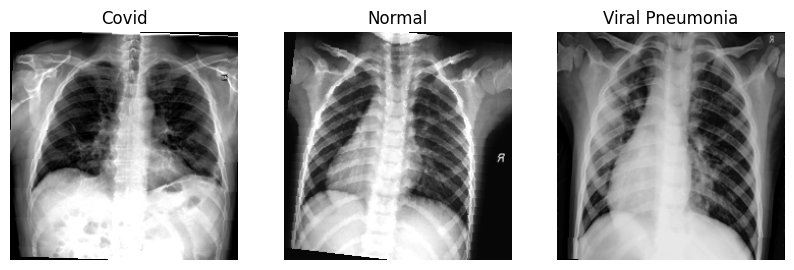

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes  # This gives the class folder names
print("Class names:", class_names)
# Define mean and std for denormalizing (same as used in normalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize the image
def denormalize(img, mean, std):
    img = img.clone()  # Clone the tensor to avoid modifying the original
    for i in range(3):  # Apply denormalization per channel
        img[i] = img[i] * std[i] + mean[i]
    return img

# Dictionary to store one image per class
images_per_class = {}

# Iterate over the test dataset to get one image per class
for img, label in data_test:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == len(class_names):
        break

# Plot each image
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    img = denormalize(img, mean, std)  # Denormalize the image
    img = img.clamp(0, 1)  # Ensure values are in the range [0, 1] for display
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Class names: ['Covid', 'Normal', 'Viral Pneumonia']


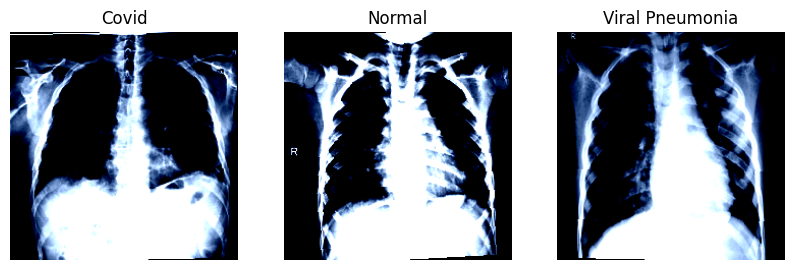

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes  # This gives the class folder names
print("Class names:", class_names)

# Dictionary to store one image per class
images_per_class = {}

# Iterate over the test dataset to get one image per class
for img, label in data_test:
    # If we don't have an image for this class label, add it to the dictionary
    if label not in images_per_class:
        images_per_class[label] = img
    # Stop if we have one image per class
    if len(images_per_class) == len(class_names):
        break

# Plot each image
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from Tensor shape [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Define model

In [ ]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

class CovidXrayClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, lr=0.0001):
        super(CovidXrayClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Dropout(p=0.6), nn.Linear(num_ftrs, num_classes))
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        # Přidávám atribut držící POSLEDNI VRSTVU resnetu -> pro heat maps
        self.target_layer = self.model.layer4[-1]

        # Store epoch-level metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.val_accuracy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        self.train_accs.append(self.trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self):
        self.val_losses.append(self.trainer.callback_metrics["val_loss"].item())
        self.val_accs.append(self.trainer.callback_metrics["val_acc"].item())

    #def on_train_epoch_end(self):
        # Store metrics for plotting after each epoch
        #if "train_loss" in self.trainer.callback_metrics:
           # self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        #if "train_acc" in self.trainer.callback_metrics:
           # self.train_accs.append(self.trainer.callback_metrics["train_acc"].item())

    #def on_validation_epoch_end(self):
        # Store metrics for plotting after each epoch
        #if "val_loss" in self.trainer.callback_metrics:
           # self.val_losses.append(self.trainer.callback_metrics["val_loss"].item())
        #if "val_acc" in self.trainer.callback_metrics:
            #self.val_accs.append(self.trainer.callback_metrics["val_acc"].item())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-3)
        scheduler = OneCycleLR(optimizer, max_lr=self.lr, steps_per_epoch=len(train_loader), epochs=EPOCHS)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


Train model

In [ ]:
# Initialize and train model
model = CovidXrayClassifier()
#trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu', callbacks=[early_stop_callback])
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Results

In [ ]:
torch.save(model.state_dict(), "model.pth")     # ukládáme model pro heat maps - viz níže

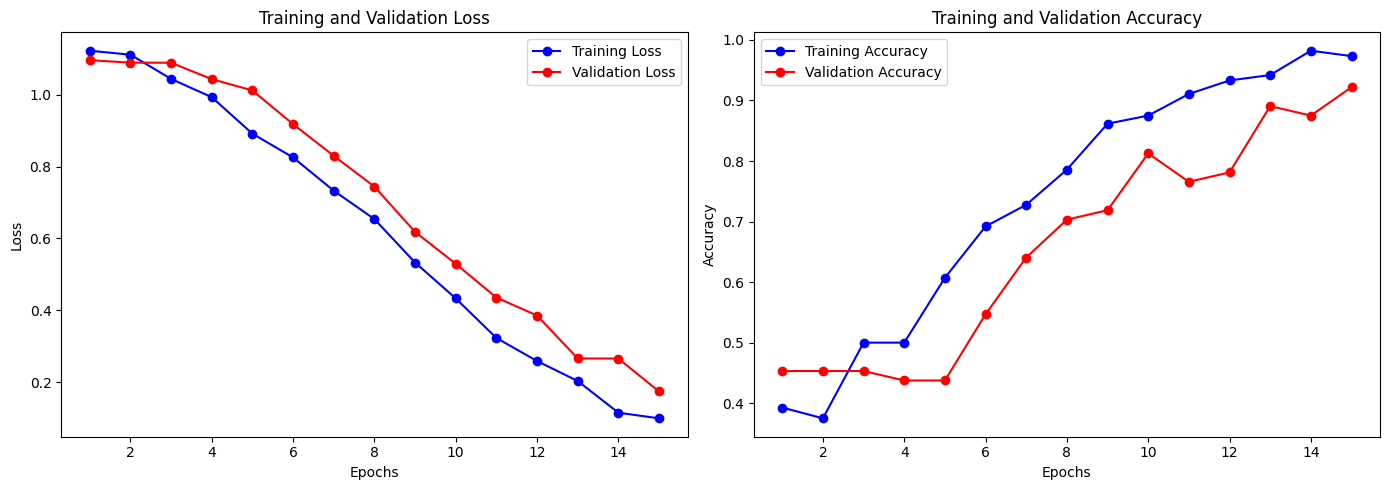

In [ ]:
def align_lists(*lists):
    min_length = min(len(lst) for lst in lists)
    return [lst[:min_length] for lst in lists]

# Call the alignment function
train_losses, val_losses, train_accs, val_accs = align_lists(
    model.train_losses, model.val_losses, model.train_accs, model.val_accs
)

# Now, plot the metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the aligned metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs)

Best result so far: **resnet50 - acc: 0.984**

Define average loss function

Cross-Entropy Loss: Best for general multi-class classification tasks where class distribution is relatively balanced.
Focal Loss: Useful for imbalanced datasets or when you want to pay more attention to harder examples.
KL Divergence Loss: Good when working with soft labels or probabilistic predictions.
Label Smoothing Cross-Entropy: Helps to improve generalization and avoid overfitting by preventing the model from being too confident.

**NEXT UP...**
<h2>Heat maps</h2>

In [ ]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

<ipython-input-19-e5679bdf4a69>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


CovidXrayClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()

        output[:, target_class].backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        cam = torch.nn.functional.interpolate(cam, size=(input_tensor.shape[2], input_tensor.shape[3]), mode='bilinear', align_corners=False)
        cam = cam.relu()
        cam = cam / cam.max()
        return cam

In [ ]:
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((224, 224)), # kvůli ResNet se doporučuje tento resize
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

FileNotFoundError: [Errno 2] No such file or directory: '/content/path/to/your/image.jpg'

In [ ]:
target_layer = model.target_layer
grad_cam = GradCAM(model, target_layer)

In [ ]:
image = Image.open("/content/covid_0115.jpeg").convert("RGB")
input_tensor = transform(image).unsqueeze(0)

output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()
heatmap = grad_cam.generate(input_tensor, predicted_class)

# heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(input_tensor.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.title("Lung X-ray")
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(input_tensor.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.imshow(heatmap.squeeze().detach().numpy(), cmap='jet', alpha=0.5)
plt.title("Heatmap")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/0120.jpeg'